In [1]:
import glob
import numpy as np
from pathlib import Path
import shutil

def create_pcb_train_val_test(data_dir='PCBData',
                              train_dir='PCBData/train',
                              val_dir='PCBData/val',
                              test_dir='PCBData/test'
                             ):
    #all_files = glob.glob(data_dir+'/@(NG|OK)/*.jpg', flags=pathlib.GLOBSTAR | pathlib.EXTGLOB)
    ng_files = sorted(glob.glob(data_dir+"/NG/*.jpg"))
    n_ng = len(ng_files)
    ok_files = sorted(glob.glob(data_dir+"/OK/*.jpg"))
    n_ok = len(ok_files)
    #creating a new directory called pythondirectory
    Path(train_dir+'/OK').mkdir(parents=True, exist_ok=True)
    Path(train_dir+'/NG').mkdir(parents=True, exist_ok=True)
    Path(val_dir+'/OK').mkdir(parents=True, exist_ok=True)
    Path(val_dir+'/NG').mkdir(parents=True, exist_ok=True)
    np.random.seed(42)
    perm = np.random.permutation(n_ng)
    n_val = int(n_ng*0.1)//4*4
    n_train = n_ng - n_val
    src_files = ng_files
    
    train_idx = perm[:n_train]
    val_idx = perm[n_train:]
    for i in train_idx:
        src = src_files[i]
        dst = train_dir+src.replace(data_dir, '')
        shutil.copyfile(src, dst)
    for i in val_idx:
        src = src_files[i]
        dst = val_dir+src.replace(data_dir, '')
        shutil.copyfile(src, dst)
        
    perm = np.random.permutation(n_ok)
    n_val = int(n_ok*0.1)*4//4
    n_train = n_ok - n_val
    src_files = ok_files
    
    train_idx = perm[:n_train]
    val_idx = perm[n_train:]
    for i in train_idx:
        src = src_files[i]
        dst = train_dir+src.replace(data_dir, '')
        shutil.copyfile(src, dst)
    for i in val_idx:
        src = src_files[i]
        dst = val_dir+src.replace(data_dir, '')
        shutil.copyfile(src, dst)
        
#create_pcb_train_val_test()

In [2]:
from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS

In [1]:
import argparse
from pathlib import Path

import timm
import timm.data
import timm.loss
import timm.optim
import timm.utils
import torch
import torchmetrics
from timm.scheduler import CosineLRScheduler
from torchvision import transforms

from pytorch_accelerated.callbacks import SaveBestModelCallback, ProgressBarCallback
from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS
from pytorch_accelerated.run_config import TrainerRunConfig
from pytorch_accelerated.utils import local_process_zero_only

from PIL import Image

from tqdm.auto import tqdm
import time
import pandas as pd

from accelerate import notebook_launcher
import accelerate

from torch.utils.data import Dataset
import numpy as np
import glob

class PCBData(Dataset):
    def __init__(self, root_dir, transform=None, stage='val'):
        self.root_dir = root_dir
        self.transform = transform
        image_files = np.array(sorted(glob.glob('PCB_data/*/*.jpg')))
        image_labels = np.array([ 0 if filename.split('/')[1]=='NG' else 1 for filename in image_files])
        train_ratio = 0.8
        val_ratio = 0.1
        n_all = len(image_labels)
        n_ng = len(image_labels[image_labels==0])
        n_ok = n_all - n_ng
        ng_indices = np.array([i for i in range(n_ng)])
        ok_indices = np.array([i for i in range(n_ng, n_all)])
        np.random.seed(42)
        ng_perm = np.random.permutation(ng_indices)
        n_ng_train = int(n_ng*0.8)
        n_ng_val = int(n_ng*0.1)
        ng_train_indices = ng_perm[:n_ng_train]
        ng_val_indices = ng_perm[n_ng_train:n_ng_train+n_ng_val]
        ng_test_indices = ng_perm[n_ng_train+n_ng_val:]
        ok_perm = np.random.permutation(ok_indices)
        n_ok_train = int(n_ok*0.8)
        n_ok_val = int(n_ok*0.1)
        ok_train_indices = ok_perm[:n_ok_train]
        ok_val_indices = ok_perm[n_ok_train:n_ok_train+n_ok_val]
        ok_test_indices = ok_perm[n_ok_train+n_ok_val:]
        train_indices = np.concatenate((ng_train_indices, ok_train_indices))
        val_indices = np.concatenate((ng_val_indices, ok_val_indices))
        test_indices = np.concatenate((ng_test_indices, ok_test_indices))
        if stage == 'train':
            indices = train_indices
        elif stage == 'val':
            indices = val_indices
        else:
            indices = test_indices
        self.files = list(zip(image_files[indices], image_labels[indices]))
        '''
        self.classes = ['NG', 'OK']
        self.files = []
        for index, label in enumerate(self.classes):
            path = os.path.join(self.root_dir, label)
            files = os.listdir(path)
            for file in files:
                self.files.append((os.path.join(path, file), index))
        '''

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, label = self.files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def img_file(self, idx):
        return self.files[idx]

class TQDM_progressbar(ProgressBarCallback):
    """
    A callback which visualises the state of each training and evaluation epoch using a progress bar
    """

    def __init__(self):
        self.pbar = None

    def on_train_epoch_start(self, trainer, **kwargs):
        self.pbar = tqdm(
            total=len(trainer._train_dataloader),
            disable=not trainer._accelerator.is_local_main_process,
        )

    def on_train_step_end(self, trainer, **kwargs):
        self.pbar.update(1)

    def on_train_epoch_end(self, trainer, **kwargs):
        self.pbar.close()
        time.sleep(0.01)

    def on_eval_epoch_start(self, trainer, **kwargs):
        self.pbar = tqdm(
            total=len(trainer._eval_dataloader),
            disable=not trainer._accelerator.is_local_main_process,
        )

    def on_eval_step_end(self, trainer, **kwargs):
        self.pbar.update(1)

    def on_eval_epoch_end(self, trainer, **kwargs):
        self.pbar.close()
        time.sleep(0.01)

class ImageDataset_new(timm.data.dataset.ImageDataset):
    def __init__(
            self,
            root,
            reader=None,
            split='train',
            class_map=None,
            load_bytes=False,
            input_img_mode='RGB',
            transform=None,
            target_transform=None,
    ):
        super().__init__(root, reader, split, class_map, load_bytes, input_img_mode, transform, target_transform)
        
    def __getitem__(self, index):
        img, target = self.reader[index]

        '''
        try:
            img = img.read() if self.load_bytes else Image.open(img)
        except Exception as e:
            _logger.warning(f'Skipped sample (index {index}, file {self.reader.filename(index)}). {str(e)}')
            self._consecutive_errors += 1
            if self._consecutive_errors < _ERROR_RETRY:
                return self.__getitem__((index + 1) % len(self.reader))
            else:
                raise e
        '''
        self._consecutive_errors = 0

        with Image.open(img) as im:
            if self.input_img_mode and not self.load_bytes:
                img = im.convert(self.input_img_mode)
            
        if self.transform is not None:
            img = self.transform(img)

        if target is None:
            target = -1
        elif self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

import random
from typing import Sequence

class RotateTransform:
    def __init__(self, angles: Sequence[int]):
        self.angles = angles
        self.count = 0

    def __call__(self, x):
        angle = random.choice(self.angles)
        if angle == 0:
            return x
        else:
            return transforms.functional.rotate(x, angle)

#def create_datasets(image_size, data_mean, data_std, train_path, val_path):
def create_datasets(image_size, data_mean, data_std, path):
    '''
    train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        hflip=0.5,
        vflip=0.3,
        #auto_augment="rand-m7-mstd0.5-inc1",
    )

    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )
    '''
    train_transforms = transforms.Compose(
        [
            transforms.RandomCrop((224,224)),
            transforms.RandomVerticalFlip(),  # 상하반전 
            RotateTransform([0,90,180,270]),
            #transforms.RandomHorizontalFlip(),  # 좌우반전 
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
        ]
    )
    
    eval_transforms = transforms.Compose(
        [
            transforms.CenterCrop((224,224)),
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
        ]
    )

    #train_dataset = timm.data.dataset.ImageDataset_new(
    #train_dataset = ImageDataset_new(
        #train_path, transform=train_transforms, load_bytes=False
    #)
    #eval_dataset = timm.data.dataset.ImageDataset_new(val_path, transform=eval_transforms, load_bytes=False)
    #eval_dataset = ImageDataset_new(val_path, transform=eval_transforms, load_bytes=False)
    '''
    from torchvision import datasets
    train_dataset = datasets.ImageFolder(train_path, train_transforms)
    eval_dataset = datasets.ImageFolder(val_path, eval_transforms)

    return train_dataset, eval_dataset
    '''
    train_dataset = PCBData('./PCB_data', transform=train_transforms, stage='train')
    val_dataset = PCBData('./PCB_data', transform=eval_transforms, stage='val')
    test_dataset = PCBData('./PCB_data', transform=eval_transforms, stage='test')

    return train_dataset, val_dataset, test_dataset


class TimmMixupTrainer(Trainer):
    def __init__(self, eval_loss_fn, mixup_args, num_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_loss_fn = eval_loss_fn
        self.num_updates = None
        #self.mixup_fn = timm.data.Mixup(**mixup_args)

        self.accuracy = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.ema_accuracy = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.ema_model = None

    def create_scheduler(self):
        return timm.scheduler.CosineLRScheduler(
            self.optimizer,
            t_initial=self.run_config.num_epochs,
            cycle_decay=0.5,
            lr_min=1e-6,
            t_in_epochs=True,
            warmup_t=3,
            warmup_lr_init=1e-4,
            cycle_limit=1,
        )

    def training_run_start(self):
        # Model EMA requires the model without a DDP wrapper and before sync batchnorm conversion
        self.ema_model = timm.utils.ModelEmaV2(
            self._accelerator.unwrap_model(self.model), decay=0.9
        )
        if self.run_config.is_distributed:
            self.model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(self.model)

    def train_epoch_start(self):
        super().train_epoch_start()
        self.num_updates = self.run_history.current_epoch * len(self._train_dataloader)

    def calculate_train_batch_loss(self, batch):
        xb, yb = batch
        #mixup_xb, mixup_yb = self.mixup_fn(xb, yb)
        #return super().calculate_train_batch_loss((mixup_xb, mixup_yb))
        return super().calculate_train_batch_loss((xb, yb))

    def train_epoch_end(
        self,
    ):
        self.ema_model.update(self.model)
        self.ema_model.eval()

        if hasattr(self.optimizer, "sync_lookahead"):
            self.optimizer.sync_lookahead()

        # learning rate log
        self.run_history.update_metric("lr", self.optimizer.param_groups[0]['lr'])

    def scheduler_step(self):
        self.num_updates += 1
        if self.scheduler is not None:
            self.scheduler.step_update(num_updates=self.num_updates)

    def calculate_eval_batch_loss(self, batch):
        with torch.no_grad():
            xb, yb = batch
            outputs = self.model(xb)
            val_loss = self.eval_loss_fn(outputs, yb)
            self.accuracy.update(outputs.argmax(-1), yb)

            if self.ema_model is not None:
                ema_model_preds = self.ema_model.module(xb).argmax(-1)
                self.ema_accuracy.update(ema_model_preds, yb)

        return {"loss": val_loss, "model_outputs": outputs, "batch_size": xb.size(0)}

    def eval_epoch_end(self):
        super().eval_epoch_end()

        if self.scheduler is not None:
            self.scheduler.step(self.run_history.current_epoch + 1)

        self.run_history.update_metric("accuracy", self.accuracy.compute().cpu())
        self.run_history.update_metric(
            "ema_model_accuracy", self.ema_accuracy.compute().cpu()
        )
        self.accuracy.reset()
        self.ema_accuracy.reset()

data_path='PCB_data'
# Set training arguments, hardcoded here for clarity
image_size = (224, 224)
#lr = 5e-3
lr = 0.00015
smoothing = 0.1
mixup = 0.2
cutmix = 1.0
batch_size = 32
bce_target_thresh = 0.2
num_epochs = 20

data_path = Path(data_path)
train_path = data_path / "train"
val_path = data_path / "val"

num_classes = len(list(data_path.iterdir()))

mixup_args = dict(
    mixup_alpha=mixup,
    cutmix_alpha=cutmix,
    label_smoothing=smoothing,
    num_classes=num_classes,
)

# Create model using timm
model = timm.create_model(
    #"resnet50d", pretrained=True, num_classes=num_classes, drop_path_rate=0.05
    #"efficientnet_b4.ra2_in1k", pretrained=True, num_classes=num_classes, drop_path_rate=0.05
    #"davit_tiny", pretrained=True, num_classes=num_classes, drop_path_rate=0.05
    "davit_small", pretrained=True, num_classes=num_classes, drop_path_rate=0.10
    #"davit_tiny", pretrained=True, num_classes=num_classes, drop_path_rate=0.05
    #"davit_tiny", pretrained=True, num_classes=num_classes
    #"efficientvit_b3.r224_in1k", pretrained=True, num_classes=num_classes
    #"vit_base_patch16_clip_224.openai", pretrained=True, num_classes=num_classes
    #"vit_base_patch16_224", pretrained=True, num_classes=num_classes
)

# Load data config associated with the model to use in data augmentation pipeline
data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
data_mean = data_config["mean"]
data_std = data_config["std"]

class PCB_model(torch.nn.Module):
    def __init__(self, model):
        super().__init__()

        self.backbone = model 
        #self.softmax = torch.nn.Softmax(dim=1)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.softmax(x)
        return x

model = PCB_model(model)

# Create training and validation datasets
train_dataset, eval_dataset, test_dataset = create_datasets(
    path = data_path,
    #train_path=train_path,
    #val_path=val_path,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
)

def my_train():
    # Create optimizer
    optimizer = timm.optim.create_optimizer_v2(
        model, opt="lookahead_AdamW", lr=lr, weight_decay=0.01
    )

    # As we are using Mixup, we can use BCE during training and CE for evaluation
    #train_loss_fn = timm.loss.BinaryCrossEntropy(
    #    target_threshold=bce_target_thresh, smoothing=smoothing
    #)
    #train_loss_fn = torch.nn.CrossEntropyLoss()
    #validate_loss_fn = torch.nn.CrossEntropyLoss()
    train_loss_fn = torch.nn.NLLLoss()
    validate_loss_fn = torch.nn.NLLLoss()

    default_callbacks = list(DEFAULT_CALLBACKS)
    default_callbacks.pop(3)

    # Create trainer and start training
    trainer = TimmMixupTrainer(
        model=model,
        optimizer=optimizer,
        loss_func=train_loss_fn,
        eval_loss_fn=validate_loss_fn,
        mixup_args=mixup_args,
        num_classes=num_classes,
        callbacks=[
            #*DEFAULT_CALLBACKS,
            *default_callbacks,
            SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True),
            TQDM_progressbar,
        ],
    )

    trainer.train(
        per_device_batch_size=batch_size,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        num_epochs=num_epochs,
        create_scheduler_fn=trainer.create_scheduler,
    )
    
    @local_process_zero_only
    def save_history():
        #print(trainer.run_history.get_metric_names())
        train_loss_epoch = trainer.run_history.get_metric_values('train_loss_epoch')
        eval_loss_epoch = trainer.run_history.get_metric_values('eval_loss_epoch')
        accuracy = trainer.run_history.get_metric_values('accuracy')
        accuracy = [acc.numpy() for acc in accuracy]
        lr = trainer.run_history.get_metric_values('lr')
        df = pd.DataFrame(data={'train_loss': train_loss_epoch,
                                'val_loss': eval_loss_epoch,
                                'val_acc': accuracy,
                                'lr': lr,
                               })
        df.to_csv('train_history.csv', index=False)
        #print(trainer.scheduler._get_lr())

    save_history()
    
    #trainer.evaluate(
    #    per_device_batch_size=batch_size,
    #    dataset=eval_dataset,
    #)

'''
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Simple example of training script using timm.")
    parser.add_argument("--data_dir", required=True, help="The data folder on disk.")
    #args = parser.parse_args(args=['--data_dir=imagenette2-320'])
    args = parser.parse_args(args=['--data_dir=PCBData'])
    main(args.data_dir)
'''

notebook_launcher(my_train, num_processes=4)
#my_train()

Launching training on 4 GPUs.


/home/kotech/venv-lightning/lib/python3.8/site-packages/pytorch_accelerated/trainer.py:708: UserWarning: The per device batch size 32 with the eval dataset size 1275 and the number of processes 4 will cause one process to have a smaller number of samples on the last batch than the rest, which would lead to a `Trainer.gather` to freeze indefinitely. This can be resolved by passing a `padding_value` to the `Trainer.gather`.
  warnings.warn(
/home/kotech/venv-lightning/lib/python3.8/site-packages/pytorch_accelerated/trainer.py:708: UserWarning: The per device batch size 32 with the eval dataset size 1275 and the number of processes 4 will cause one process to have a smaller number of samples on the last batch than the rest, which would lead to a `Trainer.gather` to freeze indefinitely. This can be resolved by passing a `padding_value` to the `Trainer.gather`.
  warnings.warn(
/home/kotech/venv-lightning/lib/python3.8/site-packages/pytorch_accelerated/trainer.py:708: UserWarning: The per d


Starting training run

Starting epoch 1


  0%|          | 0/80 [00:00<?, ?it/s]

/home/kotech/venv-lightning/lib/python3.8/site-packages/torch/autograd/__init__.py:266: UserWarning: Grad strides do not match bucket view strides. This may indicate grad was not created according to the gradient layout contract, or that the param's strides changed since DDP was constructed.  This is not an error, but may impair performance.
grad.sizes() = [768, 1, 3, 3], strides() = [9, 1, 3, 1]
bucket_view.sizes() = [768, 1, 3, 3], strides() = [9, 9, 3, 1] (Triggered internally at ../torch/csrc/distributed/c10d/reducer.cpp:322.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/kotech/venv-lightning/lib/python3.8/site-packages/torch/autograd/__init__.py:266: UserWarning: Grad strides do not match bucket view strides. This may indicate grad was not created according to the gradient layout contract, or that the param's strides changed since DDP was constructed.  This is not an error, but may impair performance.
grad.sizes() = [768, 1


train_loss_epoch: 0.2649039626121521


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.948235273361206

ema_model_accuracy: 0.792941153049469

lr: 0.0001

eval_loss_epoch: 0.1373595893383026

Starting epoch 2


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.15377391874790192


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.948235273361206

ema_model_accuracy: 0.8007842898368835

lr: 0.00013333333333333334

eval_loss_epoch: 0.1261451095342636

Starting epoch 3


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.1409802883863449


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.9529411792755127

ema_model_accuracy: 0.8274509906768799

lr: 0.00014187998605203337

eval_loss_epoch: 0.11853132396936417

Starting epoch 4


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.1250707507133484


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.9537255167961121

ema_model_accuracy: 0.8525490164756775

lr: 0.00013577176608093358

eval_loss_epoch: 0.11167453974485397

Starting epoch 5


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.12049195915460587


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.95686274766922

ema_model_accuracy: 0.8721568584442139

lr: 0.00012817945519839777

eval_loss_epoch: 0.10697390139102936

Starting epoch 6


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.11350159347057343


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.9607843160629272

ema_model_accuracy: 0.8949019312858582

lr: 0.00011929000129578923

eval_loss_epoch: 0.09832047671079636

Starting epoch 7


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.11214040219783783


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.9592157006263733

ema_model_accuracy: 0.9137254953384399

lr: 0.00010932229223059623

eval_loss_epoch: 0.10289658606052399

Starting epoch 8


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.10471244901418686


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.9599999785423279

ema_model_accuracy: 0.930980384349823

lr: 9.852176608093358e-05

eval_loss_epoch: 0.1024639680981636

Starting epoch 9


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.10468544811010361


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.9615686535835266

ema_model_accuracy: 0.9443137049674988

lr: 8.71543676454972e-05

eval_loss_epoch: 0.09956841170787811

Starting epoch 10


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.09645512700080872


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.9592157006263733

ema_model_accuracy: 0.9529411792755127

lr: 7.549999999999999e-05

eval_loss_epoch: 0.10546274483203888

Starting epoch 11


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.09360462427139282


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.9592157006263733

ema_model_accuracy: 0.9560784101486206

lr: 6.384563235450281e-05

eval_loss_epoch: 0.10570592433214188

Starting epoch 12


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.09021482616662979


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.955294132232666

ema_model_accuracy: 0.9592157006263733

lr: 5.247823391906642e-05

eval_loss_epoch: 0.10927985608577728

Starting epoch 13


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.08694712817668915


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.955294132232666

ema_model_accuracy: 0.9599999785423279

lr: 4.167770776940376e-05

eval_loss_epoch: 0.1118554174900055

Starting epoch 14


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.08294270187616348


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.9615686535835266

ema_model_accuracy: 0.9599999785423279

lr: 3.170999870421075e-05

eval_loss_epoch: 0.10968992114067078

Starting epoch 15


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.07900653779506683


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.9592157006263733

ema_model_accuracy: 0.9592157006263733

lr: 2.2820544801602213e-05

eval_loss_epoch: 0.1100856140255928

Starting epoch 16


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.07861568033695221


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.9584313631057739

ema_model_accuracy: 0.9592157006263733

lr: 1.5228233919066423e-05

eval_loss_epoch: 0.11144887655973434

Starting epoch 17


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.07430368661880493


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.9584313631057739

ema_model_accuracy: 0.9592157006263733

lr: 9.120013947966599e-06

eval_loss_epoch: 0.11152119934558868

Starting epoch 18


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.07287175953388214


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.9592157006263733

ema_model_accuracy: 0.9599999785423279

lr: 4.6462895360110614e-06

eval_loss_epoch: 0.11110265552997589

Starting epoch 19


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.07278501987457275


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.9576470851898193

ema_model_accuracy: 0.9592157006263733

lr: 1.9172186256622444e-06

eval_loss_epoch: 0.11122433841228485

Starting epoch 20


  0%|          | 0/80 [00:00<?, ?it/s]


train_loss_epoch: 0.07269762456417084


  0%|          | 0/10 [00:00<?, ?it/s]


accuracy: 0.9592157006263733

ema_model_accuracy: 0.9592157006263733

lr: 1e-06

eval_loss_epoch: 0.11122319102287292
Finishing training run
Loading checkpoint with accuracy: 0.9615686535835266 from epoch 9


In [4]:
model

PCB_model(
  (backbone): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [2]:
!cp train_history.csv train_history_davit.csv
!cp best_model.pt best_model_davit.pt

In [3]:
df = pd.read_csv('train_history_davit.csv')
df

train_loss  val_loss   val_acc        lr
0     0.264904  0.137360  0.948235  0.000100
1     0.153774  0.126145  0.948235  0.000133
2     0.140980  0.118531  0.952941  0.000142
3     0.125071  0.111675  0.953726  0.000136
4     0.120492  0.106974  0.956863  0.000128
5     0.113502  0.098320  0.960784  0.000119
6     0.112140  0.102897  0.959216  0.000109
7     0.104712  0.102464  0.960000  0.000099
8     0.104685  0.099568  0.961569  0.000087
9     0.096455  0.105463  0.959216  0.000075
10    0.093605  0.105706  0.959216  0.000064
11    0.090215  0.109280  0.955294  0.000052
12    0.086947  0.111855  0.955294  0.000042
13    0.082943  0.109690  0.961569  0.000032
14    0.079007  0.110086  0.959216  0.000023
15    0.078616  0.111449  0.958431  0.000015
16    0.074304  0.111521  0.958431  0.000009
17    0.072872  0.111103  0.959216  0.000005
18    0.072785  0.111224  0.957647  0.000002
19    0.072698  0.111223  0.959216  0.000001

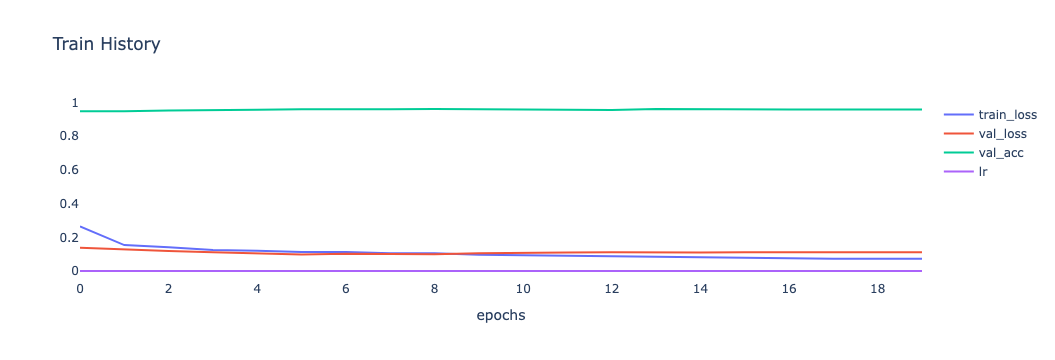

In [4]:
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import plot



data = [go.Scatter(x=df.index,
                   y=df[col],
                   name=col) for col in df.columns]

layout = go.Layout(
    plot_bgcolor="white",
    title='Train History',
    xaxis=dict(title='epochs')
)

fig = go.Figure(data=data, layout=layout)
fig.show()

In [5]:
import timm
import timm.optim
# Create optimizer
optimizer = timm.optim.create_optimizer_v2(
    model, opt="lookahead_AdamW", lr=lr, weight_decay=0.01
)

# As we are using Mixup, we can use BCE during training and CE for evaluation
train_loss_fn = timm.loss.BinaryCrossEntropy(
    target_threshold=bce_target_thresh, smoothing=smoothing
)
validate_loss_fn = torch.nn.CrossEntropyLoss()
eval_trainer = TimmMixupTrainer(
    model=model,
    optimizer=optimizer,
    loss_func=train_loss_fn,
    eval_loss_fn=validate_loss_fn,
    mixup_args=mixup_args,
    num_classes=num_classes,
    callbacks=[
        *DEFAULT_CALLBACKS,
        #TQDM_progressbar,
    ],
)
eval_trainer.load_checkpoint('best_model.pt', load_optimizer=False)
eval_trainer.evaluate(
        per_device_batch_size=batch_size,
        dataset=eval_dataset,
      )


Starting evaluation run


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 39/40 [00:03<00:00, 15.21it/s]/home/kotech/venv-lightning/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning:

The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.83it/s]


accuracy: 0.9615686535835266

ema_model_accuracy: 0.0

evaluation_loss: 0.09956841170787811
Finishing evaluation run


In [6]:
eval_trainer.evaluate(
        per_device_batch_size=batch_size,
        dataset=test_dataset,
      )


Starting evaluation run


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.56it/s]


accuracy: 0.9631949663162231

ema_model_accuracy: 0.0

evaluation_loss: 0.10356047004461288
Finishing evaluation run


In [7]:
eval_trainer.evaluate(
        per_device_batch_size=batch_size,
        dataset=train_dataset,
      )


Starting evaluation run


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [00:21<00:00, 14.90it/s]


accuracy: 0.9619831442832947

ema_model_accuracy: 0.0

evaluation_loss: 0.09392640739679337
Finishing evaluation run


In [8]:
def create_eval_datasets(image_size, data_mean, data_std, train_path, val_path):
    '''
    train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        hflip=0.5,
        vflip=0.3,
        #auto_augment="rand-m7-mstd0.5-inc1",
    )

    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )
    '''
    train_transforms = transforms.Compose(
        [
            #transforms.CenterCrop((224,224)),
            #transforms.RandomCrop((224,224)),
            #transforms.RandomHorizontalFlip(),  # 좌우반전 
            #RotateTransform([0,90,180,270]),
            #transforms.RandomVerticalFlip(),  # 상하반전 
            #transforms.RandomVerticalFlip(),  # 상하반전 
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
        ]
    )
    
    eval_transforms = transforms.Compose(
        [
            #transforms.CenterCrop((224,224)),
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
        ]
    )

    #train_dataset = timm.data.dataset.ImageDataset_new(
    #train_dataset = ImageDataset_new(
        #train_path, transform=train_transforms, load_bytes=False
    #)
    #eval_dataset = timm.data.dataset.ImageDataset_new(val_path, transform=eval_transforms, load_bytes=False)
    #eval_dataset = ImageDataset_new(val_path, transform=eval_transforms, load_bytes=False)
    from torchvision import datasets
    #train_dataset = datasets.ImageFolder(train_path, train_transforms)
    #eval_dataset = datasets.ImageFolder(val_path, eval_transforms)
    train_dataset = PCBData('./PCB_data', transform=eval_transforms, stage='train')
    val_dataset = PCBData('./PCB_data', transform=eval_transforms, stage='val')
    test_dataset = PCBData('./PCB_data', transform=eval_transforms, stage='test')

    return train_dataset, val_dataset, test_dataset
    
train2_dataset, val2_dataset, test2_dataset = create_eval_datasets(
    train_path=train_path,
    val_path=val_path,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
)
eval_trainer.evaluate(
        per_device_batch_size=batch_size,
        dataset=train2_dataset,
      )


Starting evaluation run


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [00:29<00:00, 10.78it/s]


accuracy: 0.9586517810821533

ema_model_accuracy: 0.0

evaluation_loss: 0.09990645945072174
Finishing evaluation run


https://github.com/huggingface/accelerate/blob/main/examples/cv_example.py

In [9]:
#model.load_state_dict(torch.load('best_model_res.pt')['model_state_dict'])
device = torch.device('cuda')
#model.to(device)
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=64)
y_pred = []
y_true = []
for i, batch in enumerate(eval_dataloader):
    # We could avoid this line since we set the accelerator with `device_placement=True`.
    x, y = batch
    x = x.to(device)
    with torch.no_grad():
        outputs = model(x)
    predictions = outputs.argmax(dim=-1).to('cpu')
    y_pred.append(predictions)
    y_true.append(y)
    #print(predictions)
    #print(y)
    #predictions, references = accelerator.gather_for_metrics((predictions, batch["label"]))
    #accurate_preds = predictions == references
    #num_elems += accurate_preds.shape[0]
    #accurate += accurate_preds.long().sum()

In [10]:
y_pred = torch.cat(y_pred).numpy()
y_true = torch.cat(y_true).numpy()

In [11]:
# accuracy
acc = (y_true == y_pred).sum()/len(y_pred)
print('accuracy =', acc)

accuracy = 0.9615686274509804


accuracy_score: 0.9615686274509804
              precision    recall  f1-score   support

           0     0.9792    0.9724    0.9758      1015
           1     0.8951    0.9192    0.9070       260

    accuracy                         0.9616      1275
   macro avg     0.9371    0.9458    0.9414      1275
weighted avg     0.9620    0.9616    0.9618      1275



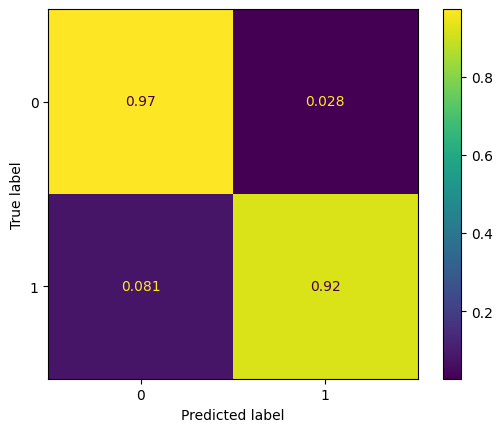

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
print('accuracy_score:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))
c = confusion_matrix(y_true, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()

In [13]:
dataset = eval_dataset
n_data = len(dataset)
indices = np.array([i for i in range(n_data)])

In [14]:
print(n_data)
print(len(indices[(y_true==0)&(y_pred==1)]))
print(len(indices[(y_true==1)&(y_pred==0)]))
print(len(indices[y_true!=y_pred]))
print(len(indices[y_true==y_pred]))

1275
28
21
49
1226


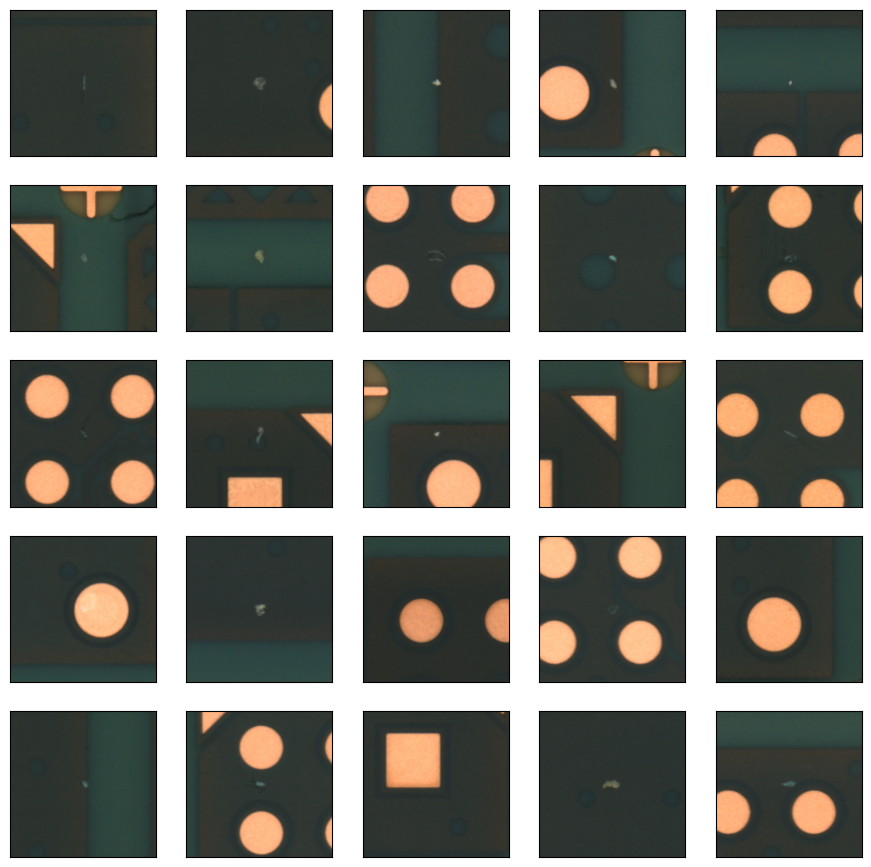

In [15]:
from matplotlib import image as mp_image
import numpy as np

plt.figure(figsize=(11,11))

indices_01 =indices[(y_true==0)&(y_pred==1)] 
perm = np.random.permutation(indices_01)
for i, idx in enumerate(perm[:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mp_image.imread(dataset.img_file(idx)[0])
    plt.imshow(img)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

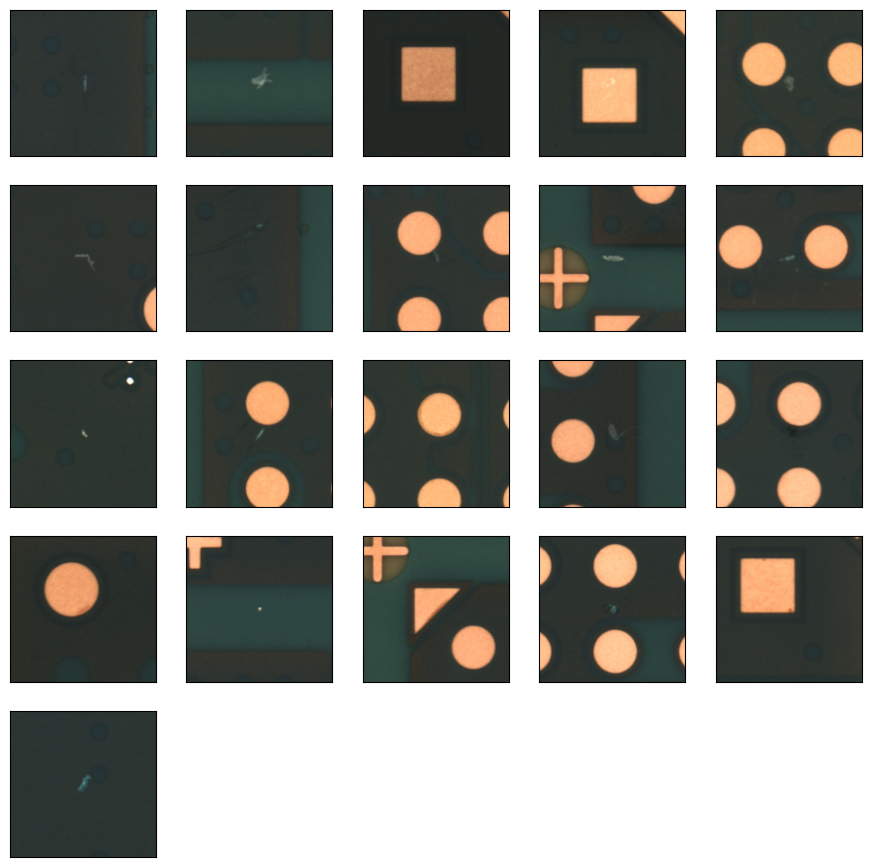

In [16]:
plt.figure(figsize=(11,11))

indices_10 =indices[(y_true==1)&(y_pred==0)] 
perm = np.random.permutation(indices_10)
for i, idx in enumerate(perm[:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mp_image.imread(dataset.img_file(idx)[0])
    plt.imshow(img)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

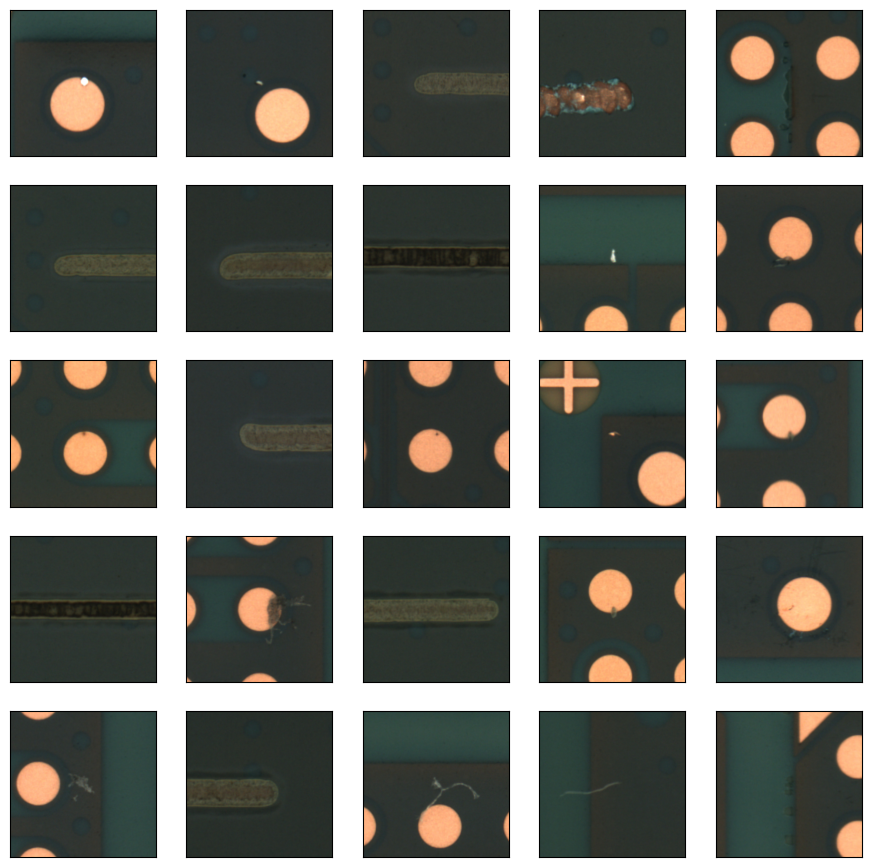

In [17]:
plt.figure(figsize=(11,11))

indices_00 =indices[(y_true==0)&(y_pred==0)] 
perm = np.random.permutation(indices_00)
for i, idx in enumerate(perm[:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mp_image.imread(dataset.img_file(idx)[0])
    plt.imshow(img)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

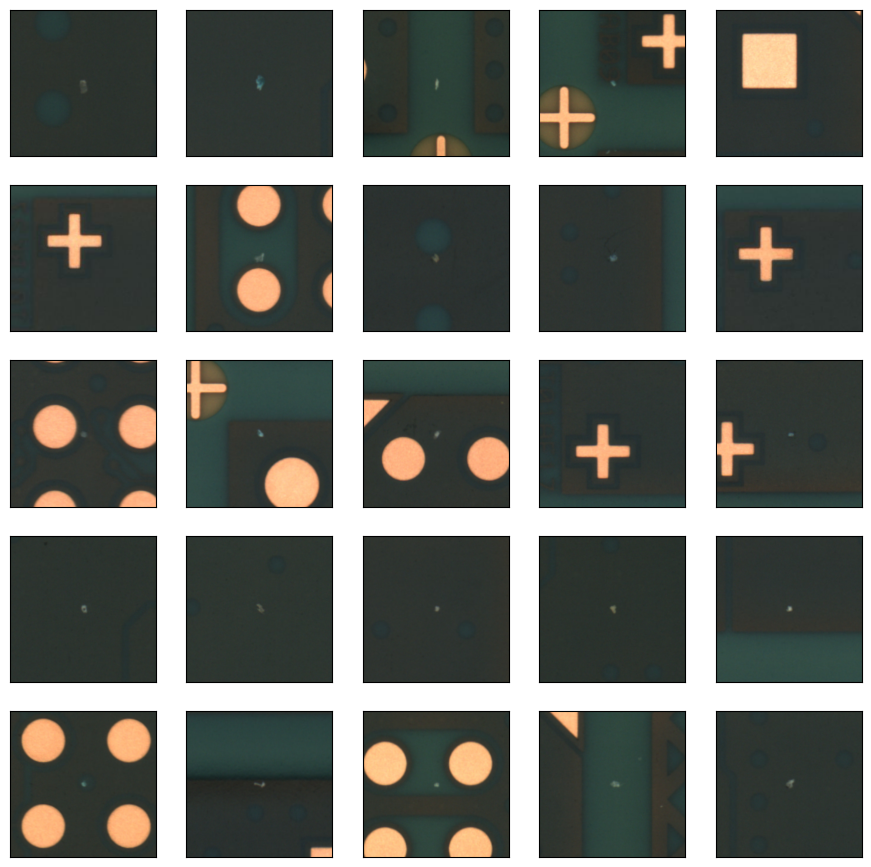

In [18]:
plt.figure(figsize=(11,11))

indices_11 =indices[(y_true==1)&(y_pred==1)] 
perm = np.random.permutation(indices_11)
for i, idx in enumerate(perm[:25]):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mp_image.imread(dataset.img_file(idx)[0])
    plt.imshow(img)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

In [37]:
import glob
import numpy as np
image_files = np.array(sorted(glob.glob('PCB_data/*/*.jpg')))
image_labels = np.array([ 0 if filename.split('/')[1]=='NG' else 1 for filename in image_files])
train_ratio = 0.8
val_ratio = 0.1
n_all = len(image_labels)
n_ng = len(image_labels[image_labels==0])
n_ok = n_all - n_ng
ng_indices = np.array([i for i in range(n_ng)])
ok_indices = np.array([i for i in range(n_ng, n_all)])
np.random.seed(42)
ng_perm = np.random.permutation(ng_indices)
n_ng_train = int(n_ng*0.8)
n_ng_val = int(n_ng*0.1)
ng_train_indices = ng_perm[:n_ng_train]
ng_val_indices = ng_perm[n_ng_train:n_ng_train+n_ng_val]
ng_test_indices = ng_perm[n_ng_train+n_ng_val:]
ok_perm = np.random.permutation(ok_indices)
n_ok_train = int(n_ok*0.8)
n_ok_val = int(n_ok*0.1)
ok_train_indices = ok_perm[:n_ok_train]
ok_val_indices = ok_perm[n_ok_train:n_ok_train+n_ok_val]
ok_test_indices = ok_perm[n_ok_train+n_ok_val:]
train_indices = np.concatenate((ng_train_indices, ok_train_indices))
val_indices = np.concatenate((ng_val_indices, ok_val_indices))
test_indices = np.concatenate((ng_test_indices, ok_test_indices))


In [29]:
ok_indices

array([10154, 10155, 10156, ..., 12755, 12756, 12757])

array([0, 0, 0, ..., 0, 0, 0])